The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.





[Dataset link ](https://www.kaggle.com/msambare/fer2013)

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,

        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = os.path.join(os.getcwd(), "input/fer2013/train/"),
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [5]:
valid_dataset = valid_datagen.flow_from_directory(directory = os.path.join(os.getcwd(), "input/fer2013/train/"),
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [6]:
test_dataset = test_datagen.flow_from_directory(directory = os.path.join(os.getcwd(), "input/fer2013/test/"),
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


In [7]:
train_dataset.image_shape

(48, 48, 3)

In [8]:
train_dataset.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [6]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

2024-02-27 00:32:31.910666: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-27 00:32:31.910690: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-27 00:32:31.910699: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-27 00:32:31.910747: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-27 00:32:31.910900: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [8]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [9]:
# Base Model Summary

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [10]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                       

In [11]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [12]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [13]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('checkpoint_model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [14]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [15]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs=100,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/100


2024-02-27 00:32:33.995968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


359/359 [==============================] - 39s 101ms/step - loss: 1.9008 - accuracy: 0.8568 - precision: 0.1778 - recall: 6.9662e-04 - auc: 0.6039 - f1_score: 0.0013 - val_loss: 1.9461 - val_accuracy: 0.8572 - val_precision: 0.8000 - val_recall: 6.9674e-04 - val_auc: 0.5836 - val_f1_score: 0.0014 - lr: 0.0010
Epoch 2/100


/Users/kuratadaisusumu/.pyenv/versions/lewagon/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


359/359 [==============================] - 35s 97ms/step - loss: 1.7629 - accuracy: 0.8572 - precision: 0.5124 - recall: 0.0099 - auc: 0.6831 - f1_score: 0.0192 - val_loss: 1.8018 - val_accuracy: 0.8573 - val_precision: 1.0000 - val_recall: 0.0012 - val_auc: 0.6751 - val_f1_score: 0.0024 - lr: 0.0010
Epoch 3/100
359/359 [==============================] - 35s 96ms/step - loss: 1.7228 - accuracy: 0.8583 - precision: 0.5904 - recall: 0.0257 - auc: 0.7030 - f1_score: 0.0490 - val_loss: 1.8756 - val_accuracy: 0.8494 - val_precision: 0.3743 - val_recall: 0.0806 - val_auc: 0.6556 - val_f1_score: 0.1319 - lr: 0.0010
Epoch 4/100
359/359 [==============================] - 35s 97ms/step - loss: 1.7035 - accuracy: 0.8591 - precision: 0.6307 - recall: 0.0326 - auc: 0.7120 - f1_score: 0.0616 - val_loss: 1.7471 - val_accuracy: 0.8593 - val_precision: 0.7829 - val_recall: 0.0207 - val_auc: 0.6967 - val_f1_score: 0.0397 - lr: 0.0010
Epoch 5/100
359/359 [==============================] - 35s 99ms/step -

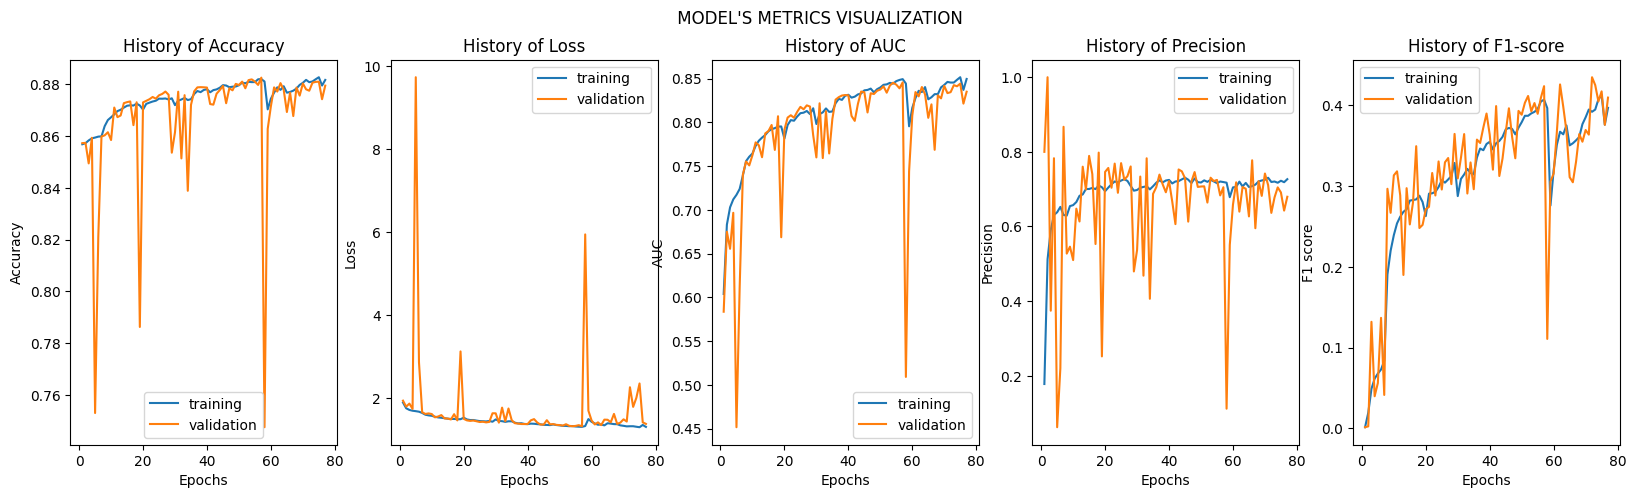

In [16]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):

    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.savefig("history_vgg_emotion_recognition_model_epoch100.png")
    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [17]:
# Evaluate the model
evaluation_result = model.evaluate(test_dataset, verbose=0)

# Print the name and value of each metric
for metric_name, metric_value in zip(model.metrics_names, evaluation_result):
    print(f"{metric_name}: {metric_value}")

loss: 1.3671602010726929
accuracy: 0.8811049461364746
precision: 0.6925783753395081
recall: 0.30161604285240173
auc: 0.8382740020751953
f1_score: 0.41936615109443665


In [18]:
model.save("vgg_emotion_recognition_model_epoch100.h5")

In [19]:
model.save("vgg_emotion_recognition_model_epoch100")

INFO:tensorflow:Assets written to: vgg_emotion_recognition_model_epoch100/assets


INFO:tensorflow:Assets written to: vgg_emotion_recognition_model_epoch100/assets
